In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from keras.models import Model,Sequential
from keras.layers import  LSTM
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression,Lasso,Ridge,ElasticNet,HuberRegressor,Lars,LassoLars,
                                  PassiveAggressiveRegressor,RANSACRegressor,SGDRegressor)
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import itertools

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [3]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [4]:
df.sort_values('Date',inplace=True)

In [5]:
df.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
138707,Materials,2260,Sahara Petrochemical Co.,2009-01-03,12.15,12.90,12.10,12.85,0.80,6.63,2617351,32610608.60,989
237007,Retailing,4050,Saudi Automotive Services Co.,2009-01-03,11.75,12.15,11.75,12.05,0.50,4.32,2767819,33195157.05,1206
73500,Materials,2020,Saudi Arabian Fertilizer Co.,2009-01-03,92.00,98.50,92.00,98.50,8.75,9.74,871456,84833829.25,999
407889,Insurance,8180,Al Sagr Cooperative Insurance Co.,2009-01-03,12.15,13.25,12.15,13.25,1.15,9.50,2091187,26429787.35,1209


In [6]:
df['Company Name'].groupby(df['Industry Group']).value_counts()

Industry Group  Company Name                           
Banks           Al Rajhi Bank                              2722
                Alinma Bank                                2722
                Arab National Bank                         2722
                Bank Albilad                               2722
                Bank Aljazira                              2722
                                                           ... 
Transportation  Saudi Public Transport Co.                 2722
                United International Transportation Co.    2722
                Saudi Ground Services Co.                  1102
Utilities       National Gas and Industrialization Co.     2722
                Saudi Electricity Co.                      2722
Name: Company Name, Length: 205, dtype: int64

In [7]:
SaudiـTelecom = df[df['Company Name']== 'Saudi Telecom Co.']

In [8]:
SaudiـTelecom_for_model = SaudiـTelecom[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [9]:
SaudiـTelecom_for_model.head(4)

,Date,Open,High,Low,Close,Change,% Change
347832,2009-01-03,49.80,52.00,49.80,51.50,2.40,4.88
347834,2009-01-04,51.75,52.50,51.25,52.00,0.50,0.97
347835,2009-01-05,52.00,53.25,51.50,52.75,0.75,1.44
347836,2009-01-06,52.00,53.00,52.00,52.50,-0.25,-0.47


In [10]:
SaudiـTelecom_for_model.reset_index(inplace=True)

In [11]:

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(SaudiـTelecom_for_model["Date"][-(227):])[0]

In [12]:
split_date

Timestamp('2019-01-01 00:00:00')

In [13]:
SaudiـTelecom_for_arima = SaudiـTelecom_for_model[['Date', 'Open', 'High', 'Low', 'Close', 'Change', '% Change']]

In [14]:
SaudiـTelecom_for_arima.set_index('Date',inplace=True)

In [15]:
training_set, test_set = SaudiـTelecom_for_model[SaudiـTelecom_for_model['Date'] < split_date], SaudiـTelecom_for_model[SaudiـTelecom_for_model['Date'] >= split_date]


In [16]:
training_set.shape

(2495, 8)

In [17]:
test_set.shape

(227, 8)

In [18]:
test_set.set_index('Date',inplace=True)

In [19]:
training_set.set_index('Date',inplace=True)

In [20]:
training_set = training_set.drop(['index'], 1)
test_set = test_set.drop(['index'], 1)

In [21]:
training = training_set.values

In [22]:
testing = test_set.values

## LSTM

## Window length

In [23]:
window_len = 5

LSTM_training_inputs = []
for i in range(len(training)-window_len):
    temp_set = training[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = training_set['Close'][window_len:].values
LSTM_training_inputs = np.array(LSTM_training_inputs)


#Create windows for testing
LSTM_test_inputs = []
for i in range(len(testing)-window_len):
    temp_set1 = testing[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set1)
LSTM_test_outputs = test_set['Close'][window_len:].values
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [24]:
LSTM_test_inputs.shape

(222, 5, 6)

In [25]:
LSTM_training_inputs.shape

(2490, 5, 6)

In [26]:
# If you want to reste the model 
# nn_model.reset_states()
# nn_model.reset_metrics()

In [27]:
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [28]:

nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 400)

nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=120, batch_size=160, verbose=1,validation_split= 0.2)

Train on 1992 samples, validate on 498 samples
Epoch 1/120
1992/1992 [==============================] - 1s 508us/step - loss: 44.2362 - val_loss: 62.7011
Epoch 2/120
1992/1992 [==============================] - 1s 294us/step - loss: 31.0135 - val_loss: 52.4710
Epoch 3/120
1992/1992 [==============================] - 1s 295us/step - loss: 24.3387 - val_loss: 46.9642
Epoch 4/120
1992/1992 [==============================] - 1s 293us/step - loss: 19.0727 - val_loss: 41.7101
Epoch 5/120
1992/1992 [==============================] - 1s 276us/step - loss: 14.3398 - val_loss: 36.6235
Epoch 6/120
1992/1992 [==============================] - 1s 287us/step - loss: 11.8831 - val_loss: 33.4323
Epoch 7/120
1992/1992 [==============================] - 1s 277us/step - loss: 11.3465 - val_loss: 31.7909
Epoch 8/120
1992/1992 [==============================] - 1s 261us/step - loss: 11.2505 - val_loss: 31.1625
Epoch 9/120
1992/1992 [==============================] - 1s 281us/step - loss: 11.1755 - val_loss

1992/1992 [==============================] - 1s 297us/step - loss: 1.1575 - val_loss: 4.3852
Epoch 78/120
1992/1992 [==============================] - 1s 299us/step - loss: 1.0895 - val_loss: 4.2097
Epoch 79/120
1992/1992 [==============================] - 1s 318us/step - loss: 1.1066 - val_loss: 4.6356
Epoch 80/120
1992/1992 [==============================] - 1s 286us/step - loss: 1.0464 - val_loss: 4.2347
Epoch 81/120
1992/1992 [==============================] - 1s 295us/step - loss: 1.0106 - val_loss: 4.2397
Epoch 82/120
1992/1992 [==============================] - 1s 280us/step - loss: 1.0243 - val_loss: 4.2539
Epoch 83/120
1992/1992 [==============================] - 1s 300us/step - loss: 1.0611 - val_loss: 4.4108
Epoch 84/120
1992/1992 [==============================] - 1s 304us/step - loss: 1.0835 - val_loss: 4.1741
Epoch 85/120
1992/1992 [==============================] - 1s 294us/step - loss: 1.0749 - val_loss: 4.0674
Epoch 86/120
1992/1992 [==============================] - 1

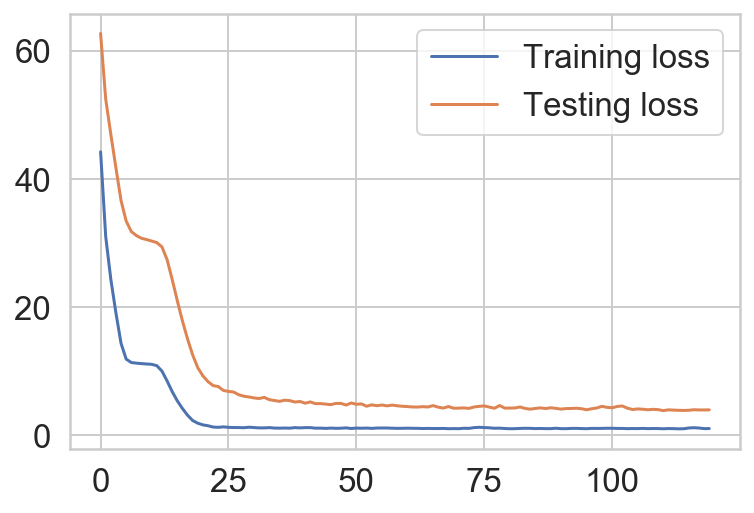

In [29]:
train_loss = nn_history.history['loss']
test_loss = nn_history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

In [30]:
#Reshape from 3D array to 2D array to fit the other models 
X_train = LSTM_training_inputs.reshape((2490,30))
X_test = LSTM_test_inputs.reshape((222,30))

## ARIMA

In [31]:
y = SaudiـTelecom_for_arima['Close'].resample('MS').mean()

In [32]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [33]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        except:
            continue
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1448.38600135389
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1211.77694588108
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1098.9029405257127
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:938.7474086942306
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:846.289686729599
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:761.1550923875748
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:881.641188599678
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:764.2964455779941
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:672.2210618639609
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:919.540171030273
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:894.834308595507
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:780.5871460755699
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:852.7105665712983
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:847.760987197921
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:762.6143776178292
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:783.6558149703602
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:763.5566835737363
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:671.2233187857896
ARIMA(0, 0, 0)x(

ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:539.0693174640833
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:473.4899394958023
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:555.6047960226786
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:557.5799769932684
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:545.9955932134195
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:526.3756653890441
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:517.6362864108908
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:504.32764290039324
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:504.5168736245449
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:491.9916118405606
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:475.9323957792419
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:725.1791482790541
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:655.8954292829561
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:595.4882823431917
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:727.6506193712521
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:614.163946355115
ARIMA(0, 2, 0)x(0, 1, 2, 12)12 - AIC:552.5884667514943
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:756.8459418891484
ARIMA(0, 2

ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:558.4404581368487
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:507.5992300264492
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:698.6793745081752
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:558.4641957528129
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:476.23755648907866
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:609.0777468401544
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:601.714909435647
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:548.6029241342682
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:585.4014227864706
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:567.0444984299282
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:507.3966953103585
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:589.7119657870268
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:544.3306420330117
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:478.5310204497768
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:556.3620321728554
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:558.2766797915299
ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:569.0851752669828
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:527.6264965671389
ARIMA(1, 0

ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:548.7714203980361
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:550.7512810102077
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:547.8593704640102
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:520.3489631183788
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:510.7817029191121
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:505.89190416831195
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:498.6495431534649
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:489.20917858044356
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:482.76755879886656
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:647.2183513122884
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:592.2006639111362
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:541.1283658638681
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:653.9782200194142
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:556.1509858928194
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:501.5609847397816
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:691.1078708105609
ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:554.8874949776146
ARIMA(1, 2, 2)x(0, 2, 2, 12)12 - AIC:470.9189607544746
ARIMA(1

ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:505.8951941103654
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:705.917004091455
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:562.137288926355
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:477.6396081967431
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:601.6234843575108
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:602.7812241565488
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:550.1792467382793
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:577.3564866319077
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:567.1014928470465
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:507.125602209178
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:581.9351865936121
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:546.6536352668818
ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:480.6610518698458
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:548.3405590445902
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:550.3381839983413
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:552.0431074219631
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:515.4155351226811
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:511.4247901411261
ARIMA(2, 1, 1

In [34]:
#ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:390.88788508639425

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,1,2),
                                seasonal_order=(0,2,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0689      0.127      0.544      0.586      -0.179       0.317
ma.L2         -0.0219      0.150     -0.146      0.884      -0.317       0.273
ma.S.L12      -1.4989      0.162     -9.266      0.000      -1.816      -1.182
ma.S.L24       0.6562      0.169      3.890      0.000       0.326       0.987
sigma2        17.7477      3.281      5.409      0.000      11.317      24.179


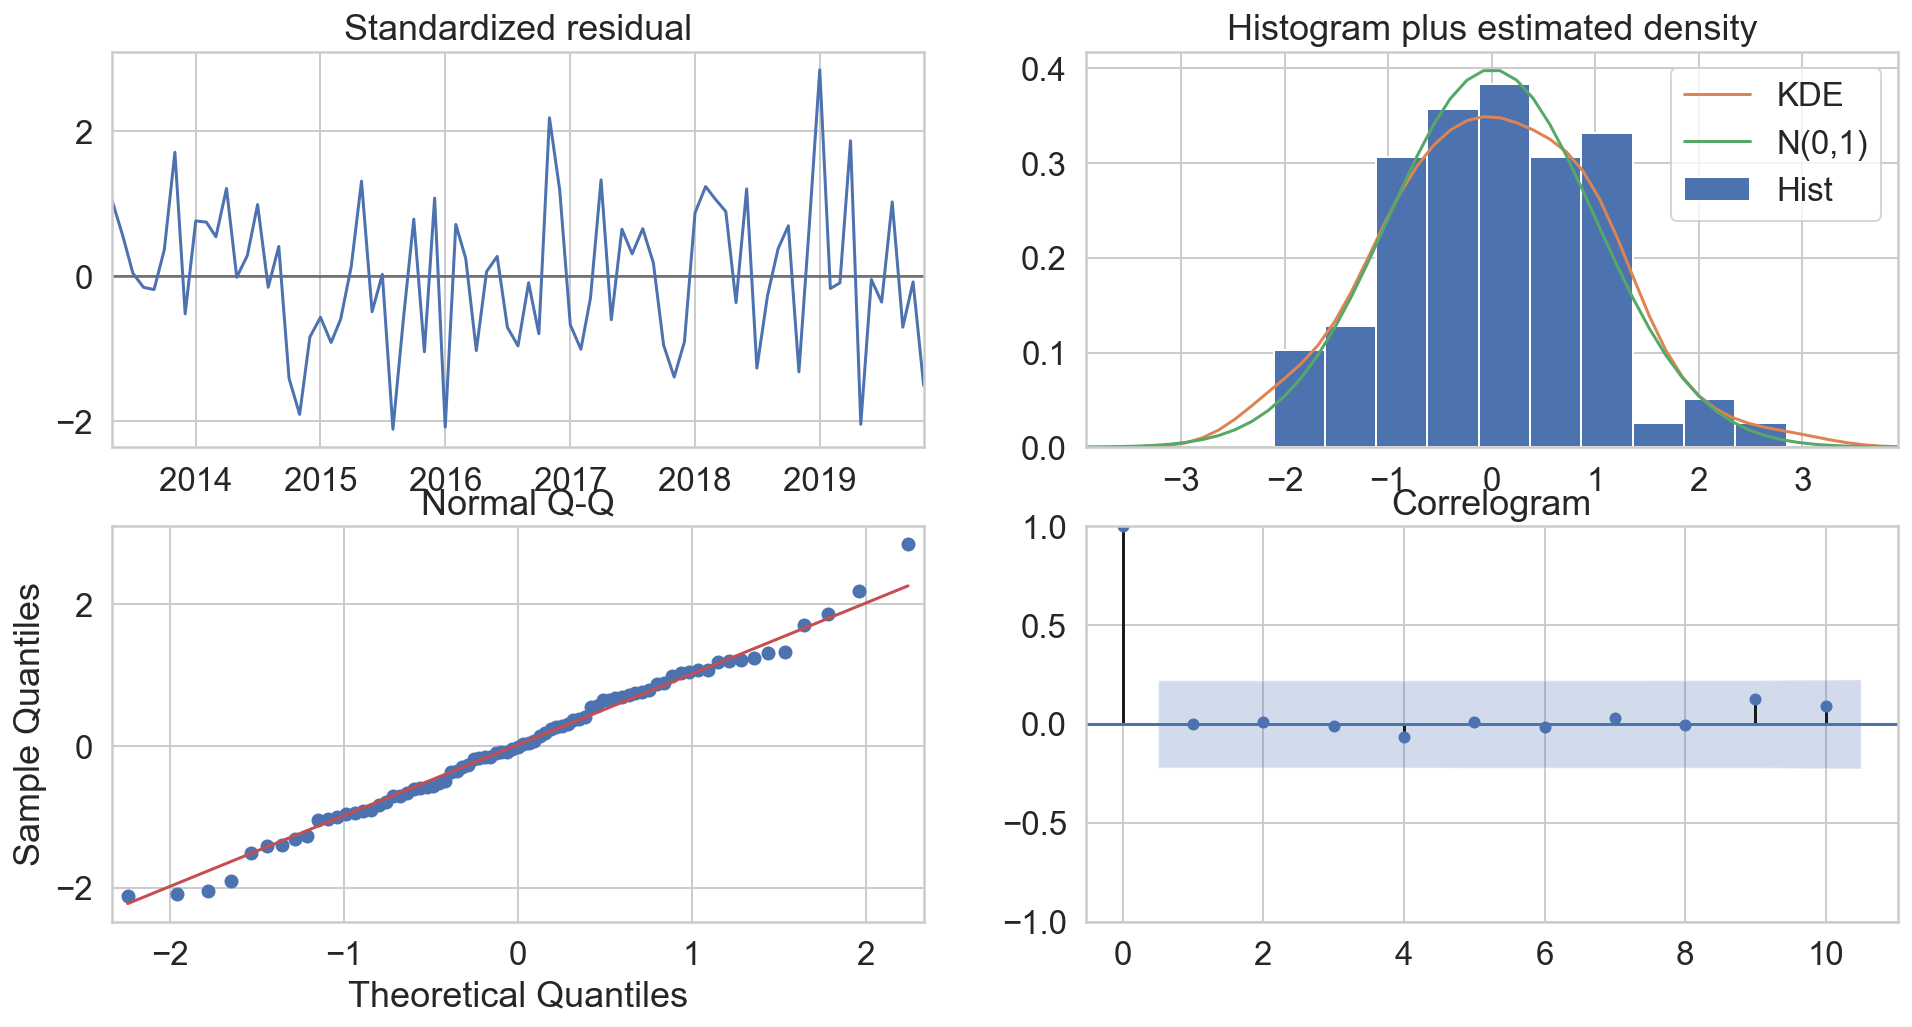

In [35]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

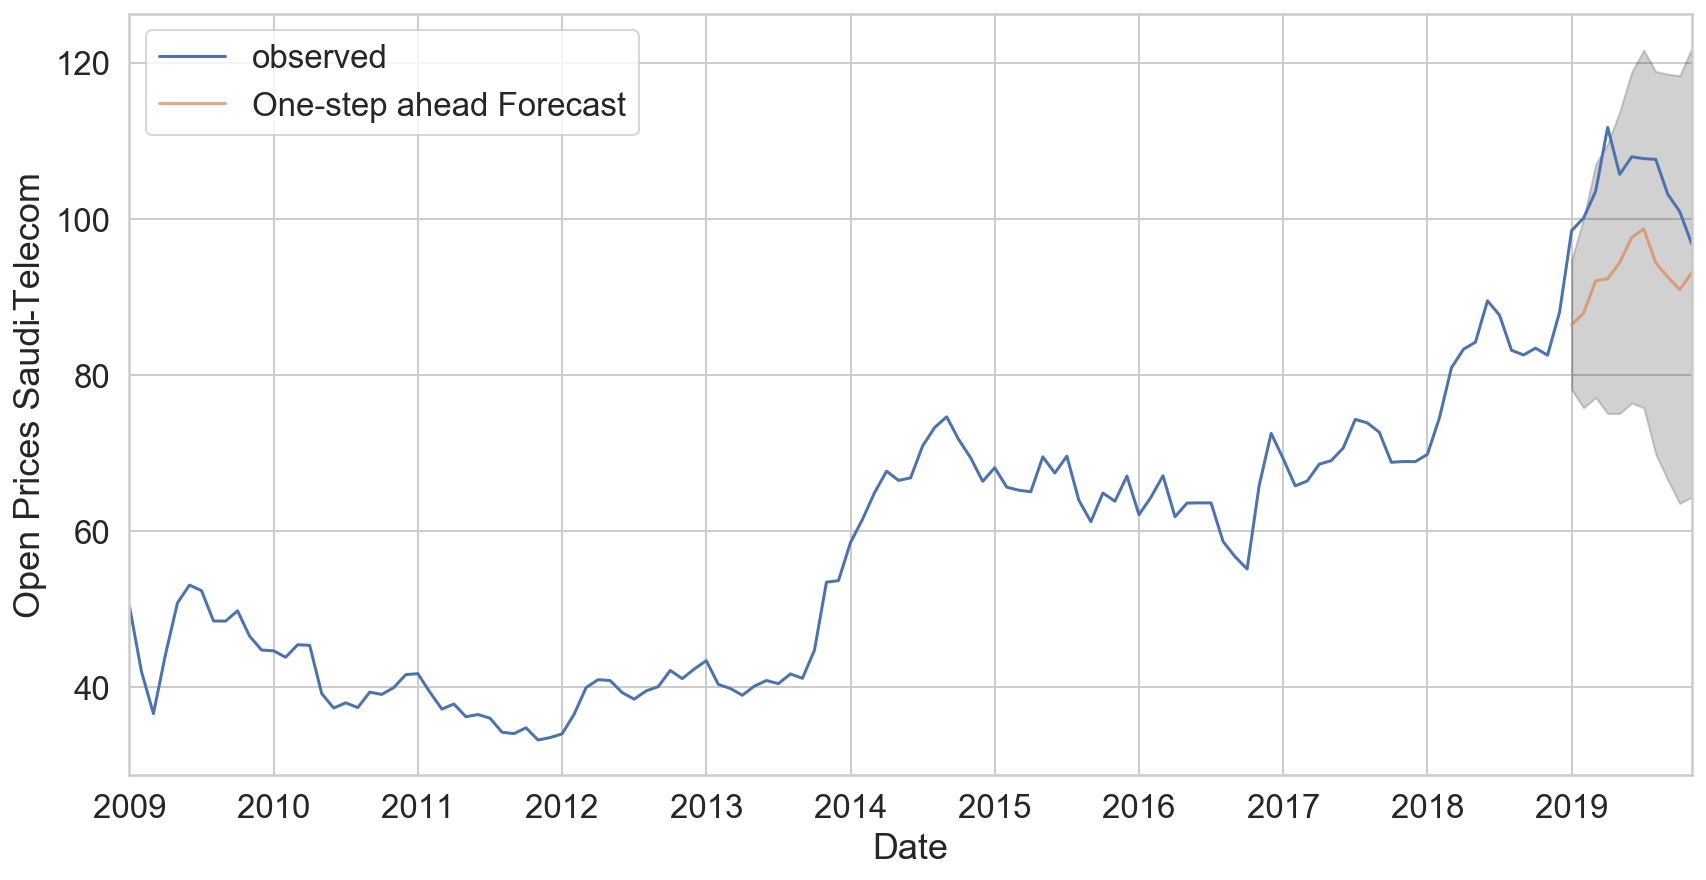

In [36]:
#Here i choose the start of 2019
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Open Prices SaudiـTelecom')
plt.legend()
plt.show()

In [37]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 137.91


In [38]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 11.74


## Producing and visualizing forecasts

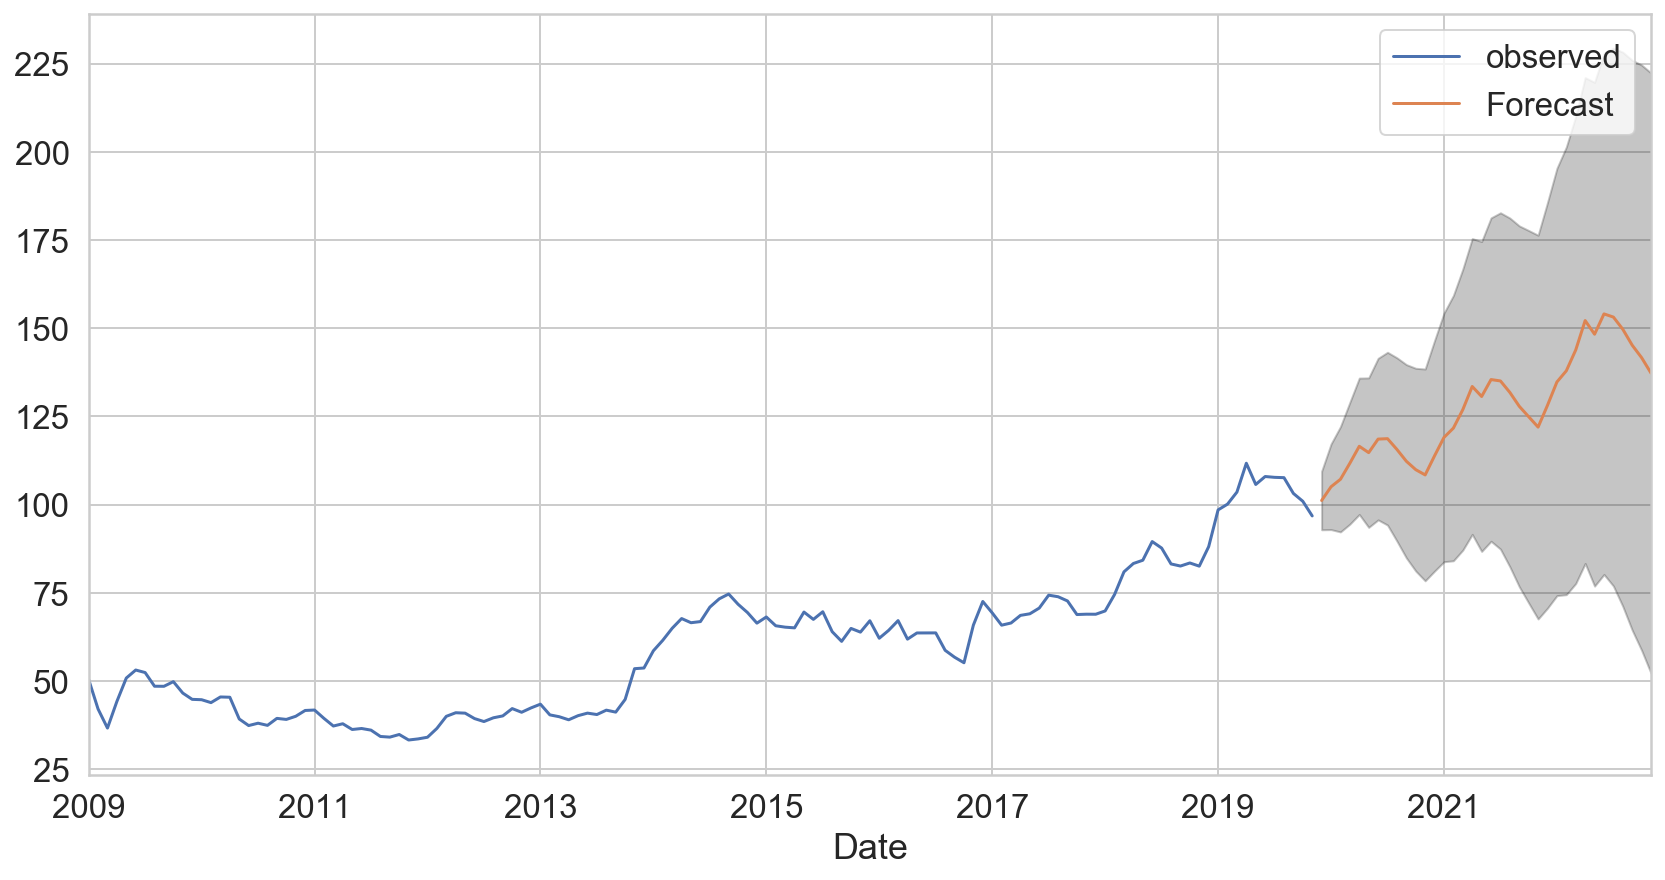

In [39]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
plt.legend()
plt.show()

## Model 

In [40]:
gboost  = GradientBoostingRegressor()
rt      = RandomForestRegressor()
lr      = LinearRegression()
lasso   = Lasso()
ridge   = Ridge()
en      = ElasticNet()
huber   = HuberRegressor()
lars    = Lars()

pa      = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
ranscac = RANSACRegressor()

mod = [lr, lasso, ridge, en, huber, lars, pa, ranscac, gboost, rt,# llars, sgd
      ]

In [41]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    model.predict(X_train)
    model.predict(X_test)


In [42]:
for i in mod:
     evaluate_model(i,X_train, LSTM_training_outputs, X_test, LSTM_test_outputs)

In [43]:
LSTM_pred = nn_model.predict(LSTM_test_inputs).T[0]

In [44]:
Lr_train_pred = lr.predict(X_train)
Lr_test_pred = lr.predict(X_test)
Lasso_train_pred = lasso.predict(X_train)
Lasso_test_pred = lasso.predict(X_test)
Ridge_train_pred = ridge.predict(X_train)
Ridge_test_pred = ridge.predict(X_test)
ElasticNet_train_pred = en.predict(X_train)
ElasticNet_test_pred = en.predict(X_test)
HuberRegressor_train_pred = huber.predict(X_train)
HuberRegressor_test_pred = huber.predict(X_test)
Lars_train_pred = lars.predict(X_train)
Lars_test_pred = lars.predict(X_test)

PassiveAggressiveRegressor_train_pred = pa.predict(X_train)
PassiveAggressiveRegressor_test_pred = pa.predict(X_test)
RANSACRegressor_train_pred = ranscac.predict(X_train)
RANSACRegressor_test_pred = ranscac.predict(X_test)

GradientBoostingRegressor_train_pred = gboost.predict(X_train)
GradientBoostingRegressor_test_pred = gboost.predict(X_test)
RandomForestRegressor_train_pred  = rt.predict(X_train)
RandomForestRegressor_test_pred  = rt.predict(X_test)

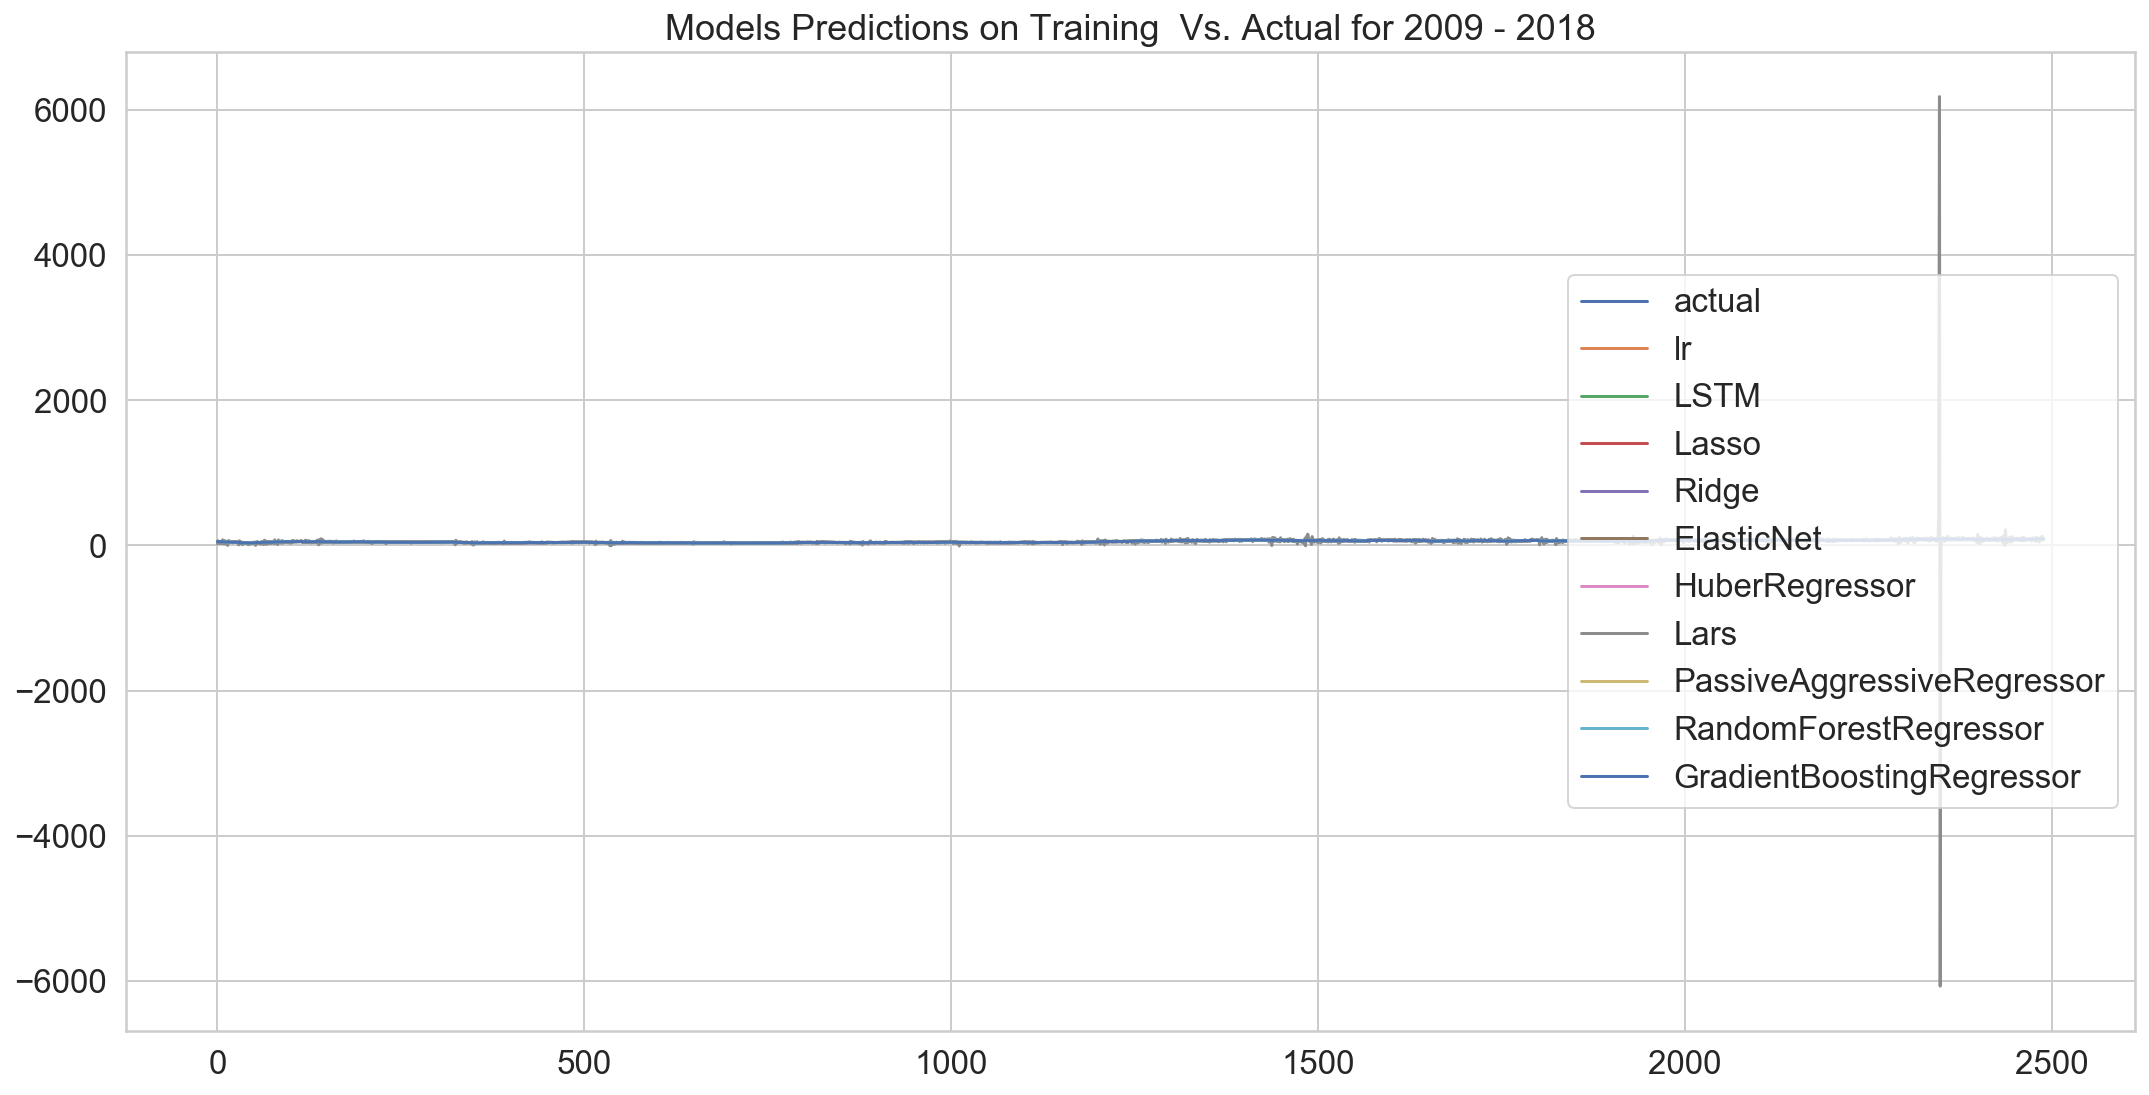

In [45]:
fig = plt.subplots( figsize=(18,9))
plt.plot(LSTM_training_outputs, label = "actual")
plt.plot(Lr_train_pred, label = "lr")
plt.plot(nn_model.predict(LSTM_training_inputs), label = "LSTM")
plt.plot(Lasso_train_pred, label = "Lasso")
plt.plot(Ridge_train_pred, label = "Ridge")
plt.plot(ElasticNet_train_pred, label = "ElasticNet")
plt.plot(HuberRegressor_train_pred, label = "HuberRegressor")
plt.plot(Lars_train_pred, label = "Lars")
# 
plt.plot(PassiveAggressiveRegressor_train_pred, label = "PassiveAggressiveRegressor")
plt.plot(RandomForestRegressor_train_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_train_pred, label = "GradientBoostingRegressor")
# plt.plot(RANSACRegressor_tradin_pred, label = "RANSACRegressor")

plt.title('Models Predictions on Training  Vs. Actual for 2009 - 2018')
plt.legend()
plt.show()

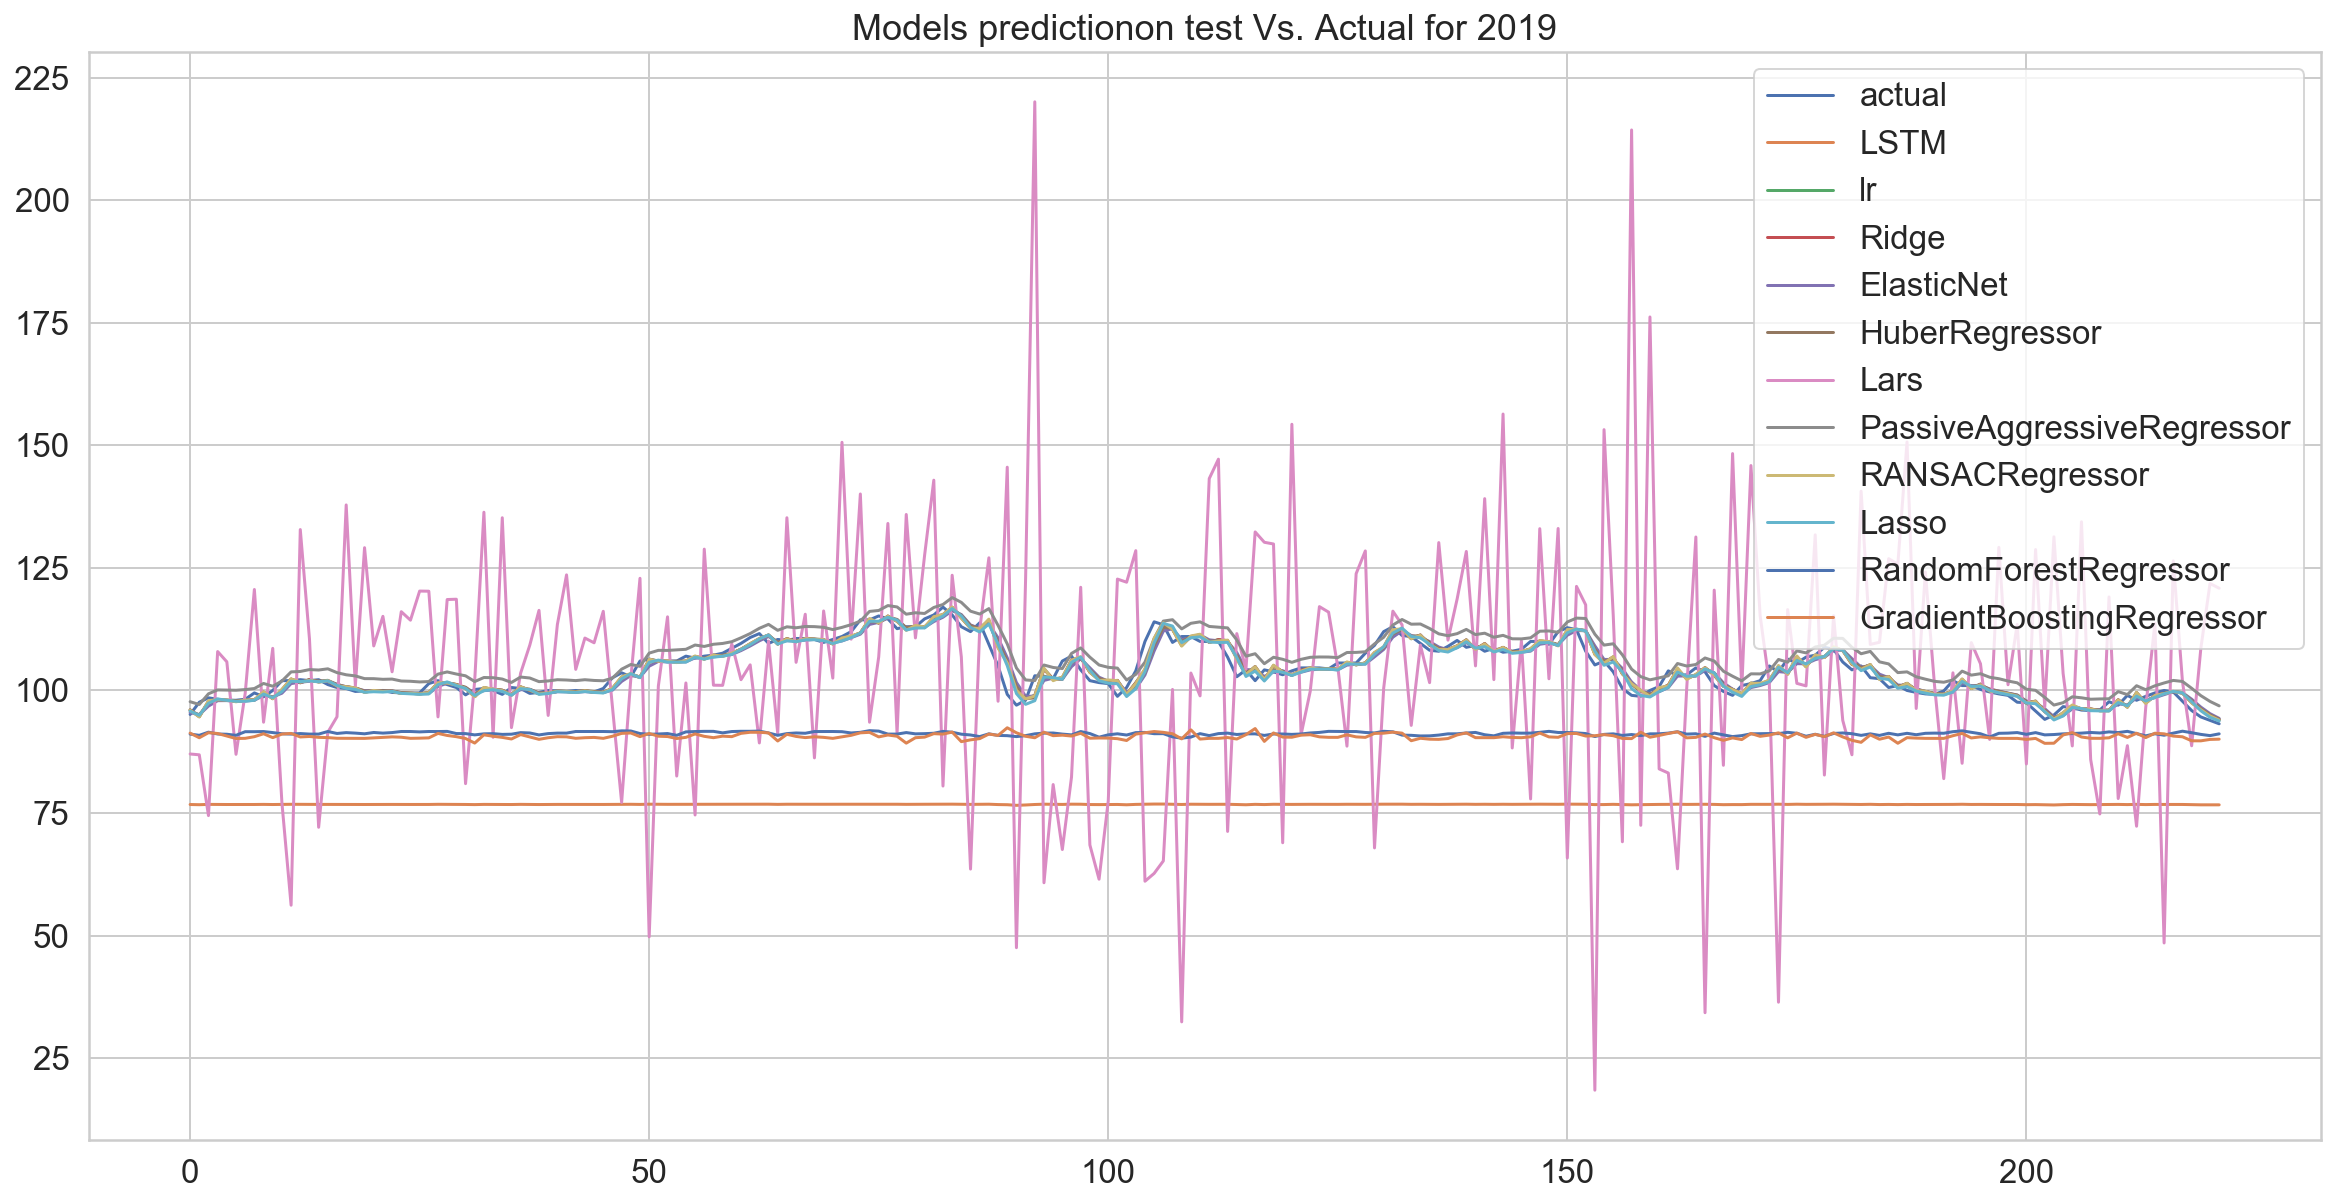

In [46]:
fig = plt.subplots( figsize=(20,10))
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "LSTM")
plt.plot(Lr_test_pred, label = "lr")
plt.plot(Ridge_test_pred, label = "Ridge")
plt.plot(ElasticNet_test_pred, label = "ElasticNet")
plt.plot(HuberRegressor_test_pred, label = "HuberRegressor")
plt.plot(Lars_test_pred, label = "Lars")

plt.plot(PassiveAggressiveRegressor_test_pred, label = "PassiveAggressiveRegressor")
plt.plot(RANSACRegressor_test_pred, label = "RANSACRegressor")

plt.plot(Lasso_test_pred, label = "Lasso")
plt.plot(RandomForestRegressor_test_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_test_pred, label = "GradientBoostingRegressor")
plt.title('Models predictionon test Vs. Actual for 2019')
plt.legend(loc=1)
plt.show()

In [47]:
predictions_test = pd.DataFrame({'Actual' : LSTM_test_outputs,
                                'Lr' : Lr_test_pred,
                                'Lasso' :Lasso_test_pred  ,
                                'Ridge':Ridge_test_pred ,
                                'ElasticNet' :ElasticNet_test_pred ,
                                'PassiveAggressiveRegressor' :PassiveAggressiveRegressor_test_pred  ,
                                'HuberRegressor': HuberRegressor_test_pred,
                                'Lars' : Lars_test_pred,
                                'RANSACRegressor' : RANSACRegressor_test_pred ,
                                'LSTM':LSTM_pred,
                                'GradientBoostingRegressor':GradientBoostingRegressor_test_pred,
                                'RandomForestRegressor':RandomForestRegressor_test_pred
                                }, 
                                columns=['Actual','Lr','Lasso', 'Ridge','ElasticNet','PassiveAggressiveRegressor',
                                        'HuberRegressor','Lars','RANSACRegressor','LSTM',  'RandomForestRegressor',
                                       'GradientBoostingRegressor' ])

In [48]:
predictions_test.head()

,Actual,Lr,Lasso,Ridge,ElasticNet,PassiveAggressiveRegressor,HuberRegressor,Lars,RANSACRegressor,LSTM,RandomForestRegressor,GradientBoostingRegressor
0,95.1,96.020995,95.783235,96.034789,95.467391,97.704935,95.849564,87.043146,95.986601,76.737724,91.10,91.301018
1,97.6,94.656198,94.935365,94.673589,95.060021,97.139664,95.020527,86.873409,94.589522,76.698059,90.85,90.355614
2,98.5,97.743604,97.373806,97.752505,96.807333,99.317937,97.402593,74.475005,97.932520,76.763199,91.49,91.381078
3,98.2,98.083765,98.268011,98.093296,97.915772,100.110786,98.153121,107.936796,98.098200,76.762100,91.12,91.221751
4,98.0,97.972368,97.998623,97.988462,97.930920,100.076637,98.017602,105.844747,98.070617,76.738960,91.07,90.706580


## Validating our model

In [49]:
df_new = pd.read_csv('NEWW-Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [50]:
df_new.Date = pd.to_datetime(df.Date, dayfirst=True)

In [51]:
df_new.sort_values('Date',inplace=True)

In [52]:
df_new.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
2121,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-03,17.06,17.06,16.78,16.90,-0.26,-1.52,147529,2494172.96,325
2123,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-04,17.38,17.38,17.18,17.18,-0.20,-1.15,142735,2465908.84,205
2133,Insurance,8290,Solidarity Saudi Takaful Co.,2009-01-05,10.32,10.36,10.30,10.34,-0.02,-0.19,47405,489919.30,106
2118,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-06,17.42,17.54,17.40,17.50,0.00,0.00,117410,2049337.42,222


In [53]:
SaudiـTelecom_2_weeks = df_new[df_new['Company Name']== 'Saudi Telecom Co.']

In [54]:
SaudiـTelecom_2_weeks

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
1764,Telecommunication Services,7010,Saudi Telecom Co.,2010-09-19,93.0,94.5,92.5,94.4,1.4,1.51,471912,44030473.5,2295
1765,Telecommunication Services,7010,Saudi Telecom Co.,2010-09-20,98.6,100.0,96.4,99.7,1.2,1.22,834871,82446062.3,1783
1763,Telecommunication Services,7010,Saudi Telecom Co.,2010-09-28,94.4,97.4,94.4,97.3,2.9,3.07,1638799,158795053.9,1227
1773,Telecommunication Services,7010,Saudi Telecom Co.,2010-09-29,96.6,99.8,96.6,98.5,1.2,1.23,1499074,146257230.1,1732
1769,Telecommunication Services,7010,Saudi Telecom Co.,2010-10-04,91.4,92.4,91.1,92.3,0.9,0.98,1535907,140547840.4,2511
1770,Telecommunication Services,7010,Saudi Telecom Co.,2010-10-05,99.8,99.8,97.6,98.0,-1.5,-1.51,487811,47949984.6,1423
1771,Telecommunication Services,7010,Saudi Telecom Co.,2010-10-06,93.0,93.2,91.1,91.4,-1.6,-1.72,1088093,99868034.8,3724
1772,Telecommunication Services,7010,Saudi Telecom Co.,2010-10-09,99.5,99.5,98.2,99.0,1.0,1.02,382979,37929078.0,1047
1766,Telecommunication Services,7010,Saudi Telecom Co.,2010-10-11,92.3,93.0,91.9,93.0,0.7,0.76,291701,26972829.9,827
1767,Telecommunication Services,7010,Saudi Telecom Co.,2011-03-05,99.6,100.2,99.2,99.5,-0.2,-0.20,639149,63686832.2,1529


In [55]:
SaudiـTelecom2w_for_model = SaudiـTelecom_2_weeks[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [56]:
SaudiـTelecom2w_for_model

,Date,Open,High,Low,Close,Change,% Change
1764,2010-09-19,93.0,94.5,92.5,94.4,1.4,1.51
1765,2010-09-20,98.6,100.0,96.4,99.7,1.2,1.22
1763,2010-09-28,94.4,97.4,94.4,97.3,2.9,3.07
1773,2010-09-29,96.6,99.8,96.6,98.5,1.2,1.23
1769,2010-10-04,91.4,92.4,91.1,92.3,0.9,0.98
1770,2010-10-05,99.8,99.8,97.6,98.0,-1.5,-1.51
1771,2010-10-06,93.0,93.2,91.1,91.4,-1.6,-1.72
1772,2010-10-09,99.5,99.5,98.2,99.0,1.0,1.02
1766,2010-10-11,92.3,93.0,91.9,93.0,0.7,0.76
1767,2011-03-05,99.6,100.2,99.2,99.5,-0.2,-0.20


In [57]:
SaudiـTelecom2w_for_model.reset_index(inplace=True)

In [58]:
asm = SaudiـTelecom_for_model[-6:]

In [59]:
asm

,index,Date,Open,High,Low,Close,Change,% Change
2716,349832,2019-11-21,100.2,100.2,99.0,99.7,-0.3,-0.30
2717,349833,2019-11-24,99.9,99.9,97.2,97.8,-1.9,-1.91
2718,349834,2019-11-25,97.8,98.4,95.9,95.9,-1.9,-1.94
2719,349835,2019-11-26,96.1,96.4,94.6,94.6,-1.3,-1.36
2720,349836,2019-11-27,95.0,95.0,92.8,93.9,-0.7,-0.74
2721,349837,2019-11-28,93.9,93.9,92.6,93.2,-0.7,-0.75


In [60]:
SaudiـTelecom2w_for_model

,index,Date,Open,High,Low,Close,Change,% Change
0,1764,2010-09-19,93.0,94.5,92.5,94.4,1.4,1.51
1,1765,2010-09-20,98.6,100.0,96.4,99.7,1.2,1.22
2,1763,2010-09-28,94.4,97.4,94.4,97.3,2.9,3.07
3,1773,2010-09-29,96.6,99.8,96.6,98.5,1.2,1.23
4,1769,2010-10-04,91.4,92.4,91.1,92.3,0.9,0.98
5,1770,2010-10-05,99.8,99.8,97.6,98.0,-1.5,-1.51
6,1771,2010-10-06,93.0,93.2,91.1,91.4,-1.6,-1.72
7,1772,2010-10-09,99.5,99.5,98.2,99.0,1.0,1.02
8,1766,2010-10-11,92.3,93.0,91.9,93.0,0.7,0.76
9,1767,2011-03-05,99.6,100.2,99.2,99.5,-0.2,-0.20


In [61]:
abr = asm.merge(SaudiـTelecom2w_for_model, how='outer')

In [62]:
abr.set_index('Date',inplace=True)

In [63]:
abr.pop('index')

Date
2019-11-21    349832
2019-11-24    349833
2019-11-25    349834
2019-11-26    349835
2019-11-27    349836
2019-11-28    349837
2010-09-19      1764
2010-09-20      1765
2010-09-28      1763
2010-09-29      1773
2010-10-04      1769
2010-10-05      1770
2010-10-06      1771
2010-10-09      1772
2010-10-11      1766
2011-03-05      1767
2011-03-06      1768
Name: index, dtype: int64

In [64]:
abr

,Open,High,Low,Close,Change,% Change
Date,,,,,,
2019-11-21,100.2,100.2,99.0,99.7,-0.3,-0.30
2019-11-24,99.9,99.9,97.2,97.8,-1.9,-1.91
2019-11-25,97.8,98.4,95.9,95.9,-1.9,-1.94
2019-11-26,96.1,96.4,94.6,94.6,-1.3,-1.36
2019-11-27,95.0,95.0,92.8,93.9,-0.7,-0.74
2019-11-28,93.9,93.9,92.6,93.2,-0.7,-0.75
2010-09-19,93.0,94.5,92.5,94.4,1.4,1.51
2010-09-20,98.6,100.0,96.4,99.7,1.2,1.22
2010-09-28,94.4,97.4,94.4,97.3,2.9,3.07


In [65]:
abr2=abr[1:].values

In [66]:
abr2

array([[ 99.9 ,  99.9 ,  97.2 ,  97.8 ,  -1.9 ,  -1.91],
       [ 97.8 ,  98.4 ,  95.9 ,  95.9 ,  -1.9 ,  -1.94],
       [ 96.1 ,  96.4 ,  94.6 ,  94.6 ,  -1.3 ,  -1.36],
       [ 95.  ,  95.  ,  92.8 ,  93.9 ,  -0.7 ,  -0.74],
       [ 93.9 ,  93.9 ,  92.6 ,  93.2 ,  -0.7 ,  -0.75],
       [ 93.  ,  94.5 ,  92.5 ,  94.4 ,   1.4 ,   1.51],
       [ 98.6 , 100.  ,  96.4 ,  99.7 ,   1.2 ,   1.22],
       [ 94.4 ,  97.4 ,  94.4 ,  97.3 ,   2.9 ,   3.07],
       [ 96.6 ,  99.8 ,  96.6 ,  98.5 ,   1.2 ,   1.23],
       [ 91.4 ,  92.4 ,  91.1 ,  92.3 ,   0.9 ,   0.98],
       [ 99.8 ,  99.8 ,  97.6 ,  98.  ,  -1.5 ,  -1.51],
       [ 93.  ,  93.2 ,  91.1 ,  91.4 ,  -1.6 ,  -1.72],
       [ 99.5 ,  99.5 ,  98.2 ,  99.  ,   1.  ,   1.02],
       [ 92.3 ,  93.  ,  91.9 ,  93.  ,   0.7 ,   0.76],
       [ 99.6 , 100.2 ,  99.2 ,  99.5 ,  -0.2 ,  -0.2 ],
       [ 93.2 ,  94.1 ,  92.8 ,  93.  ,  -0.2 ,  -0.21]])

In [67]:
X_valid = []
for i in range(len(abr2)-window_len):
    temp_set = abr2[i:(i+window_len)].copy()
    X_valid.append(temp_set)
y_valid = abr['Close'][window_len:].values
X_valid = np.array(X_valid)

In [68]:
X_valid

array([[[ 99.9 ,  99.9 ,  97.2 ,  97.8 ,  -1.9 ,  -1.91],
        [ 97.8 ,  98.4 ,  95.9 ,  95.9 ,  -1.9 ,  -1.94],
        [ 96.1 ,  96.4 ,  94.6 ,  94.6 ,  -1.3 ,  -1.36],
        [ 95.  ,  95.  ,  92.8 ,  93.9 ,  -0.7 ,  -0.74],
        [ 93.9 ,  93.9 ,  92.6 ,  93.2 ,  -0.7 ,  -0.75]],

       [[ 97.8 ,  98.4 ,  95.9 ,  95.9 ,  -1.9 ,  -1.94],
        [ 96.1 ,  96.4 ,  94.6 ,  94.6 ,  -1.3 ,  -1.36],
        [ 95.  ,  95.  ,  92.8 ,  93.9 ,  -0.7 ,  -0.74],
        [ 93.9 ,  93.9 ,  92.6 ,  93.2 ,  -0.7 ,  -0.75],
        [ 93.  ,  94.5 ,  92.5 ,  94.4 ,   1.4 ,   1.51]],

       [[ 96.1 ,  96.4 ,  94.6 ,  94.6 ,  -1.3 ,  -1.36],
        [ 95.  ,  95.  ,  92.8 ,  93.9 ,  -0.7 ,  -0.74],
        [ 93.9 ,  93.9 ,  92.6 ,  93.2 ,  -0.7 ,  -0.75],
        [ 93.  ,  94.5 ,  92.5 ,  94.4 ,   1.4 ,   1.51],
        [ 98.6 , 100.  ,  96.4 ,  99.7 ,   1.2 ,   1.22]],

       [[ 95.  ,  95.  ,  92.8 ,  93.9 ,  -0.7 ,  -0.74],
        [ 93.9 ,  93.9 ,  92.6 ,  93.2 ,  -0.7 ,  -0.75],
        

In [69]:
X_valid_resaped = X_valid.reshape(11,30)

In [70]:
y_valid

array([93.2, 94.4, 99.7, 97.3, 98.5, 92.3, 98. , 91.4, 99. , 93. , 99.5,
       93. ])

In [71]:
LSTM_valid_pred = nn_model.predict(X_valid).T[0]
Lr_valid_pred = lr.predict(X_valid_resaped)
Lasso_valid_pred = lasso.predict(X_valid_resaped)
Ridge_valid_pred = ridge.predict(X_valid_resaped)
ElasticNet_valid_pred = en.predict(X_valid_resaped)
HuberRegressor_valid_pred = huber.predict(X_valid_resaped)
Lars_valid_pred = lars.predict(X_valid_resaped)

PassiveAggressiveRegressor_valid_pred = pa.predict(X_valid_resaped)
RANSACRegressor_valid_pred = ranscac.predict(X_valid_resaped)

GradientBoostingRegressor_valid_pred = gboost.predict(X_valid_resaped)
RandomForestRegressor_valid_pred  = rt.predict(X_valid_resaped)

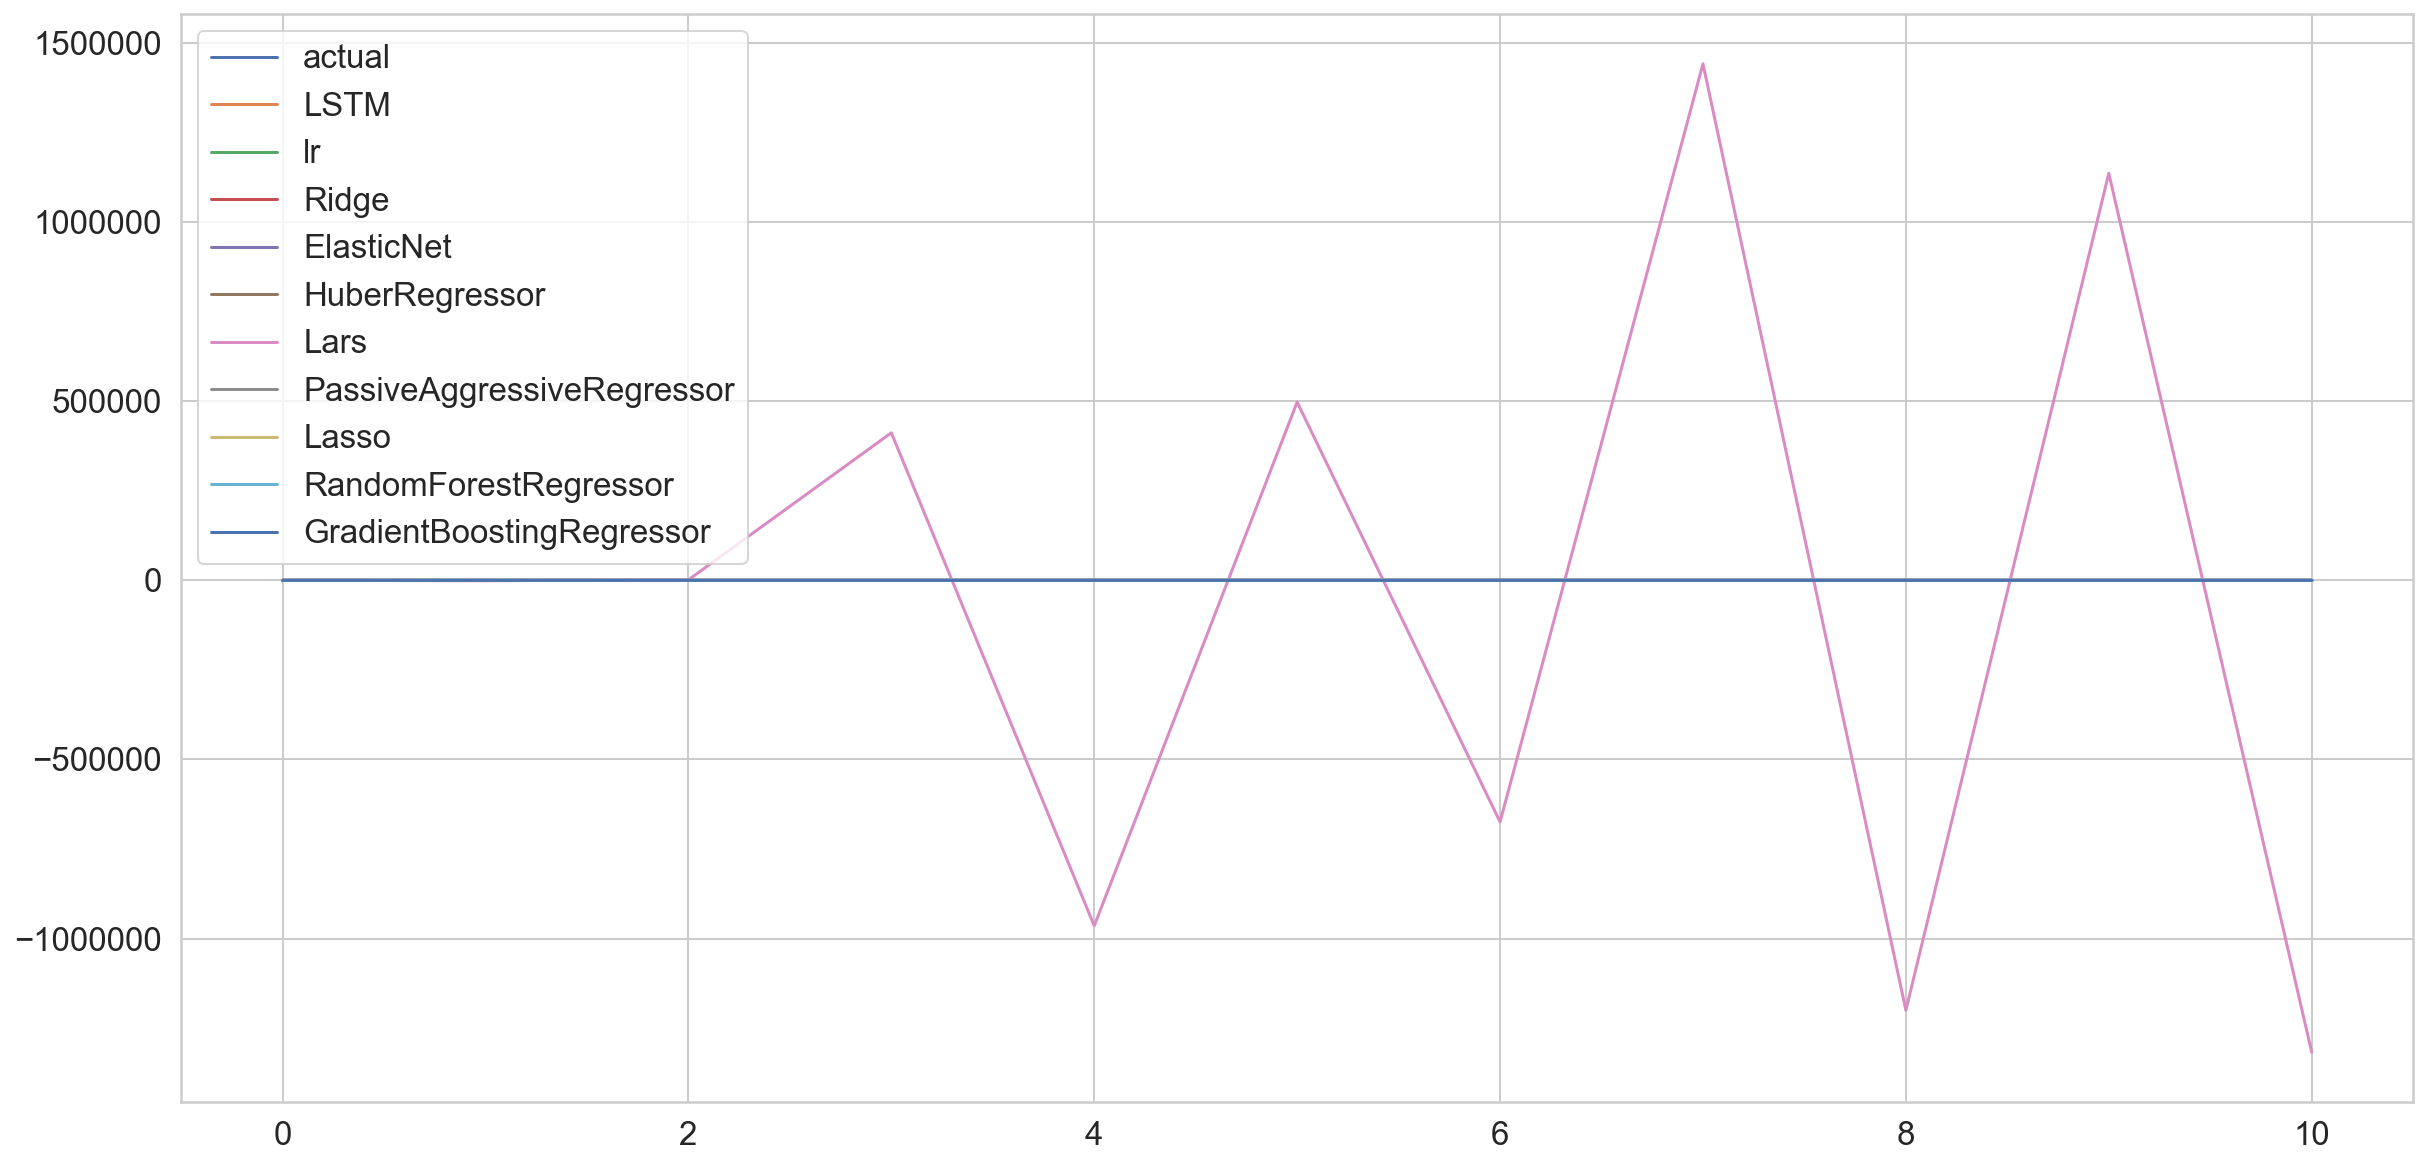

In [72]:
fig = plt.subplots( figsize=(20,10))
plt.plot(y_valid[:-1], label = "actual")
plt.plot(LSTM_valid_pred, label = "LSTM")
plt.plot(Lr_valid_pred, label = "lr")
plt.plot(Ridge_valid_pred, label = "Ridge")
plt.plot(ElasticNet_valid_pred, label = "ElasticNet")
plt.plot(HuberRegressor_valid_pred, label = "HuberRegressor")
plt.plot(Lars_valid_pred, label = "Lars")
# plt.plot(LassoLars_valid_pred, label = "LassoLars")
plt.plot(PassiveAggressiveRegressor_valid_pred, label = "PassiveAggressiveRegressor")
#plt.plot(RANSACRegressor_valid_pred, label = "RANSACRegressor")
# plt.plot(SGDRegressor_valid_pred, label = "SGDRegressor")
plt.plot(Lasso_valid_pred, label = "Lasso")
plt.plot(RandomForestRegressor_valid_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_valid_pred, label = "GradientBoostingRegressor")
plt.legend(loc=2)
plt.show()

In [73]:
R2_score_valid_LSTM = r2_score(y_valid[:-1],nn_model.predict(X_valid))

In [74]:
R2_traininig_score_LSTM = r2_score(LSTM_training_outputs,nn_model.predict(LSTM_training_inputs))

In [75]:
R2_score_test_LSTM=r2_score(LSTM_test_outputs,nn_model.predict(LSTM_test_inputs))

In [76]:
R2_score_test_LSTM

-26.23089484940217

In [77]:
R2_traininig_score_LSTM

0.9695732475701475

In [78]:
R2_score_valid_LSTM

-40.5260993333317

In [79]:
models = ['LSTM','LR', 'lasso', 'ridge', 'en', 'huber', 'lars', 'pa', #'ranscac',
          'gboost', 'rt']
Training_R2=[R2_traininig_score_LSTM,lr.score(X_train,LSTM_training_outputs),
            lasso.score(X_train,LSTM_training_outputs),ridge.score(X_train,LSTM_training_outputs), 
            en.score(X_train,LSTM_training_outputs),huber.score(X_train,LSTM_training_outputs),
            lars.score(X_train,LSTM_training_outputs),
            pa.score(X_train,LSTM_training_outputs), #ranscac.score(X_train,LSTM_training_outputs),
             gboost.score(X_train,LSTM_training_outputs), rt.score(X_train,LSTM_training_outputs)]
Test_R2=[R2_score_test_LSTM,lr.score(X_test,LSTM_test_outputs),lasso.score(X_test,LSTM_test_outputs), 
         ridge.score(X_test,LSTM_test_outputs),en.score(X_test,LSTM_test_outputs), 
         huber.score(X_test,LSTM_test_outputs),lars.score(X_test,LSTM_test_outputs), 
         pa.score(X_test,LSTM_test_outputs), 
        # ranscac.score(X_test,LSTM_test_outputs), 
         gboost.score(X_test,LSTM_test_outputs),rt.score(X_test,LSTM_test_outputs)]
valid_R2=[R2_score_valid_LSTM,lr.score(X_valid_resaped, y_valid[:-1]),lasso.score(X_valid_resaped, y_valid[:-1]), 
         ridge.score(X_valid_resaped, y_valid[:-1]),en.score(X_valid_resaped, y_valid[:-1]), 
         huber.score(X_valid_resaped, y_valid[:-1]),lars.score(X_valid_resaped, y_valid[:-1]), 
         pa.score(X_valid_resaped, y_valid[:-1]), 
         #ranscac.score(X_valid_resaped, y_valid[:-1]), 
         gboost.score(X_valid_resaped, y_valid[:-1]),rt.score(X_valid_resaped, y_valid[:-1])]

In [80]:
R2_scores = pd.DataFrame({'models' : models,
                                'Training_R2' : Training_R2,
                                'Test_R2' :Test_R2  ,
                                'valid_R2':valid_R2 ,
                                }, 
                                columns=[ 'models','Training_R2','Test_R2','valid_R2'])

In [81]:
R2_scores

,models,Training_R2,Test_R2,valid_R2
0,LSTM,0.969573,-26.230895,-4.052610e+01
1,LR,0.997303,0.911662,-3.233775e+02
2,lasso,0.997182,0.910008,9.965882e-01
3,ridge,0.997301,0.911698,8.114524e-01
4,en,0.996794,0.889470,9.317805e-01
5,huber,0.997250,0.904654,6.043889e-01
6,lars,-122.721534,-25.678769,-8.257112e+10
7,pa,0.990046,0.674159,2.656783e-02
8,gboost,0.998242,-6.329126,-2.913399e+00
9,rt,0.999417,-5.794328,-2.662897e+00


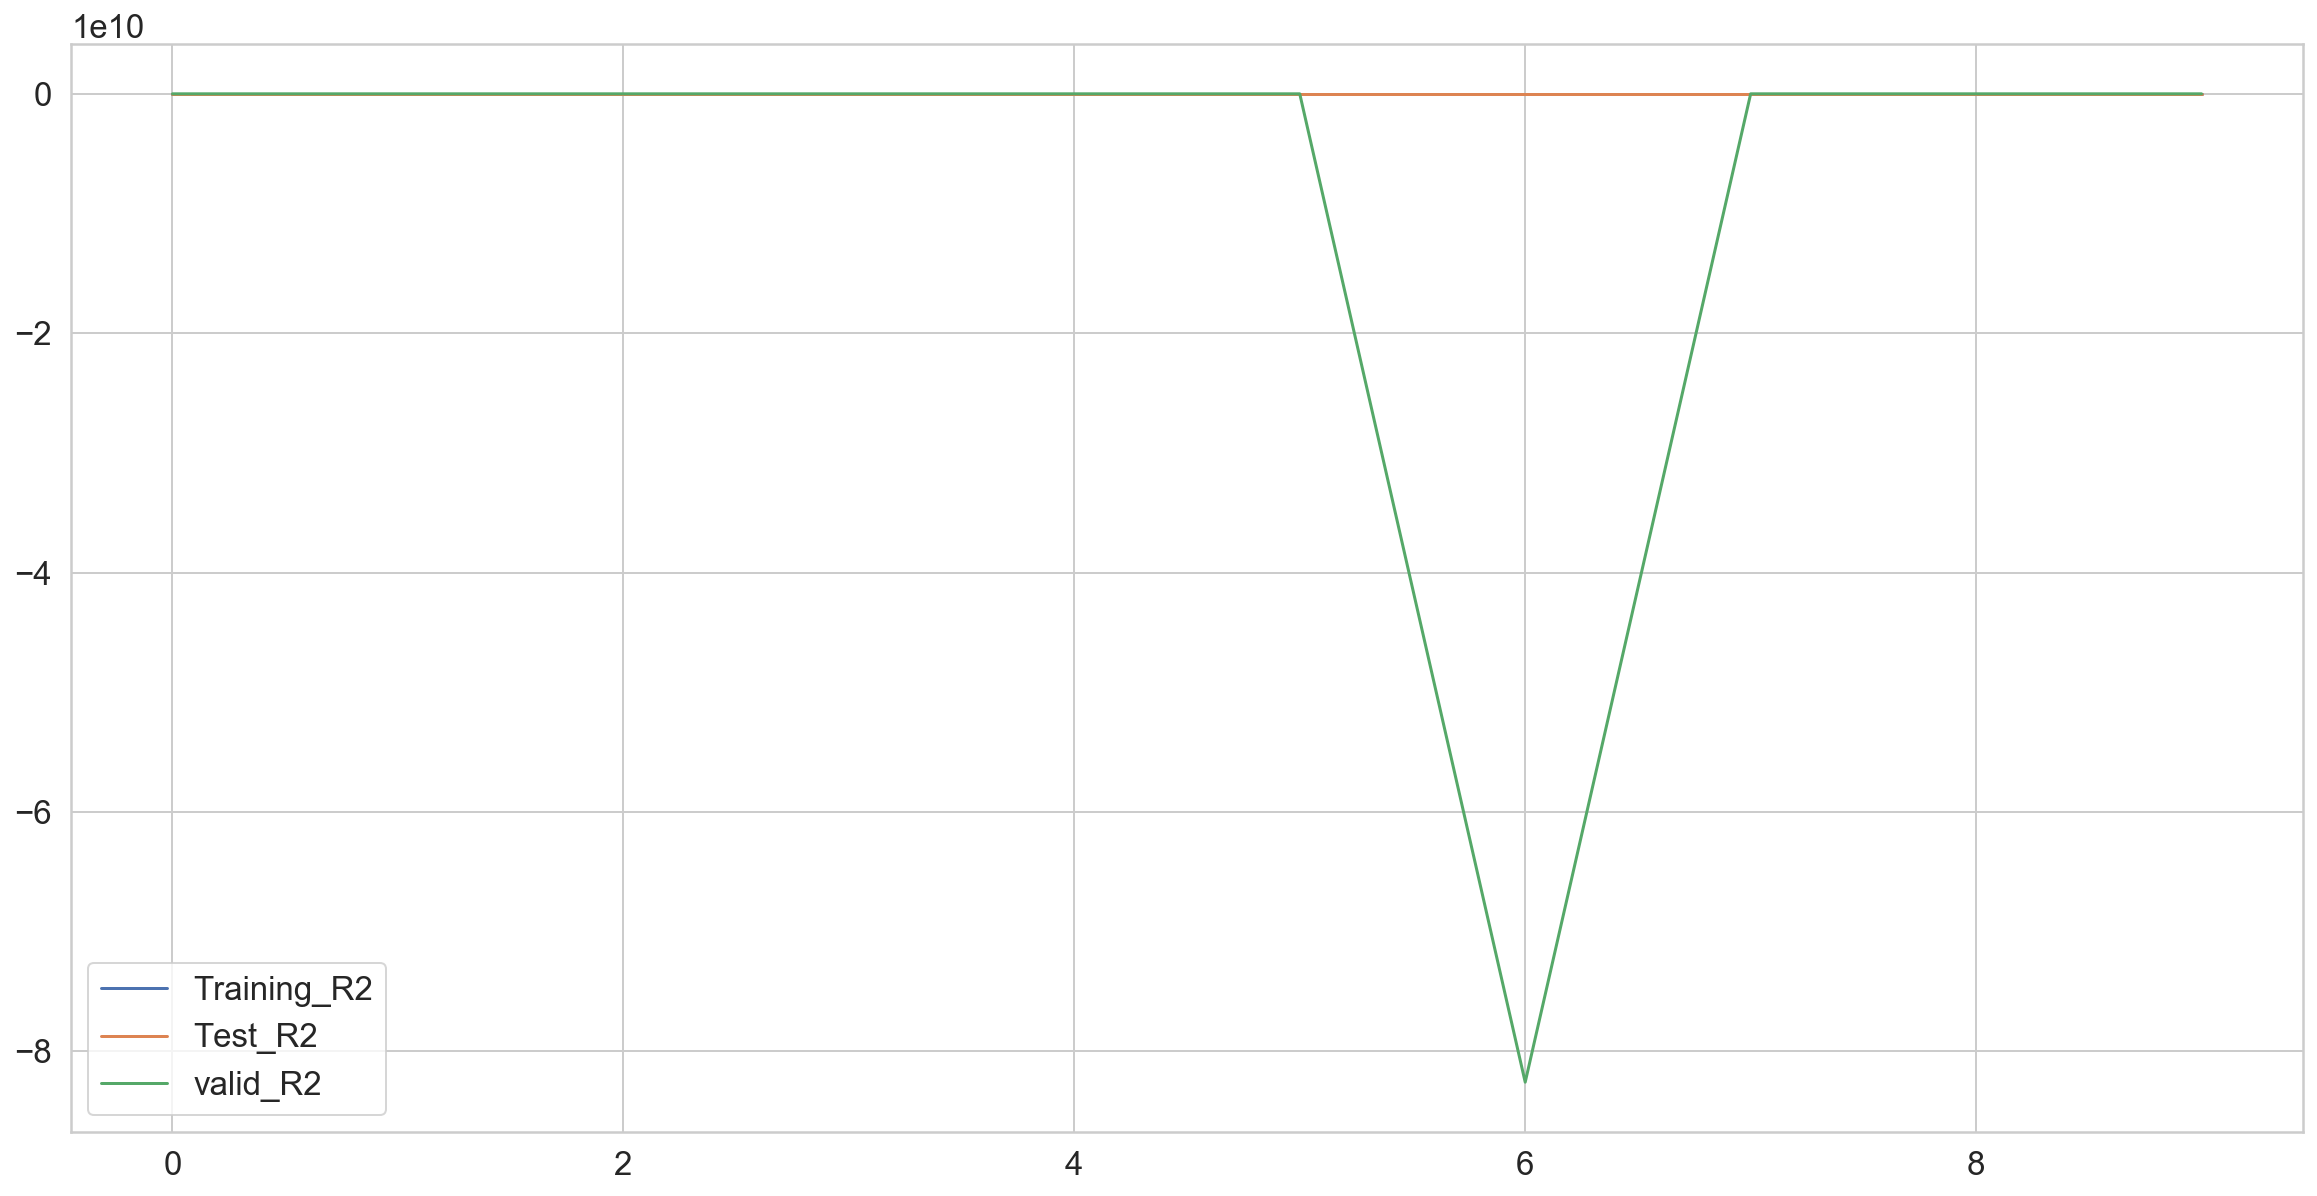

In [82]:
fig = plt.subplots( figsize=(20,10))
plt.plot(R2_scores['Training_R2'] ,label = "Training_R2")
plt.plot(R2_scores['Test_R2'] ,label = "Test_R2")
plt.plot(R2_scores['valid_R2'] ,label = "valid_R2")
xlabel=R2_scores['models']
plt.legend()
plt.show()